In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.table import QTable, join, vstack
from scipy.interpolate import interp1d

In [3]:
# Read in both the WISE-method and direct SSDF local background measurements
with (open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_frac_err_pivot.json') as f,
    open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPT-SSDF_local_bkg_no_stars.json') as g):
    spt_sdwfs = json.load(f)
    spt_ssdf = json.load(g)

In [4]:
# Read in the SPTpol 100d IR-AGN catalog (this way we only work on clusters that reside within the SSDF footprint)
sptpol_100d = QTable.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SPTpol_100d_IRAGN.fits')

# Group to only have cluster information
sptpol_100d_grp = sptpol_100d.group_by('SPT_ID')
sptpol_100d = vstack([QTable(cluster['SPT_ID', 'SZ_RA', 'SZ_DEC', 'REDSHIFT', 'M500', 'R500'][0]) for cluster in sptpol_100d_grp.groups])

In [5]:
# Recast the results into tables
spt_sdwfs_table = QTable(rows=[[cluster_name, bkg_value] for cluster_name, bkg_value in spt_sdwfs.items()],
                    names=['SPT_ID', 'local_bkg_sdwfs'], units=[None, u.deg ** -2])
spt_ssdf_table = QTable(rows=[[cluster_name, bkg_value] for cluster_name, bkg_value in spt_ssdf.items()],
                  names=['SPT_ID', 'local_bkg_ssdf'], units=[None, u.deg ** -2])
sptpol_100d = join(sptpol_100d, spt_sdwfs_table, keys='SPT_ID', join_type='left')
sptpol_100d = join(sptpol_100d, spt_ssdf_table, keys='SPT_ID', join_type='left')

In [6]:
np.mean(sptpol_100d['local_bkg_ssdf'].to(u.arcmin**-2)), np.std(sptpol_100d['local_bkg_ssdf'].to(u.arcmin**-2))

(<Quantity 0.5785713 1 / arcmin2>, <Quantity 0.20977171 1 / arcmin2>)

In [7]:
np.mean(sptpol_100d['local_bkg_sdwfs'].to(u.arcmin**-2)), np.std(sptpol_100d['local_bkg_sdwfs'].to(u.arcmin**-2))

(<Quantity 0.64619398 1 / arcmin2>, <Quantity 0.48040044 1 / arcmin2>)

In [8]:
np.mean((sptpol_100d['local_bkg_ssdf'] - sptpol_100d['local_bkg_sdwfs']).to(u.arcmin**-2)), np.std((sptpol_100d['local_bkg_ssdf'] - sptpol_100d['local_bkg_sdwfs']).to(u.arcmin**-2))

(<Quantity -0.06762268 1 / arcmin2>, <Quantity 0.42637242 1 / arcmin2>)

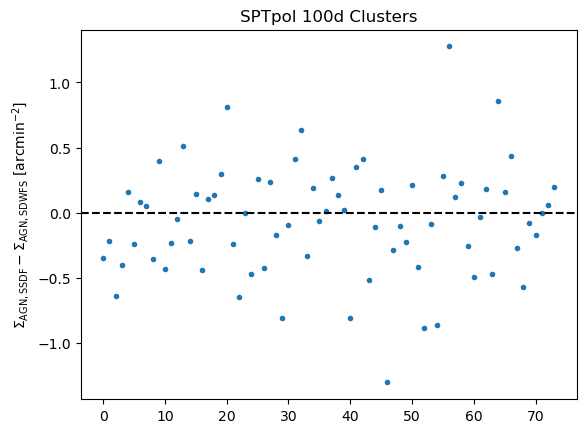

In [10]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(sptpol_100d)), (sptpol_100d['local_bkg_ssdf'] - sptpol_100d['local_bkg_sdwfs']).to(u.arcmin**-2), marker='.')
ax.axhline(y=0., ls='--', color='k')
ax.set(title='SPTpol 100d Clusters', ylabel=r'$\Sigma_{\rm AGN, SSDF} - \Sigma_{\rm AGN, SDWFS}$ [arcmin$^{-2}$]')
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/plots/cluster_agn_surf_den/local_bkg_surf_den_SSDF_check_no_stars.pdf')

In [17]:
# Read in both scaling relations
with (open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/'
          'SDWFS_WISEgal-IRACagn_scaling_factors.json', 'r') as f,
    open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/'
              'SPT_WISEgal-SDWFS_WISEgal_scaling_factors.json', 'r') as g):
    sdwfs_wise_irac_scaling_data = json.load(f)
    spt_wise_sdwfs_wise_scaling_data = json.load(g)
for d in sdwfs_wise_irac_scaling_data.values():
    for k, v in d.items():
        d[k] = np.array(v)
spt_wise_sdwfs_wise_scaling_data = {k: v for k, v in spt_wise_sdwfs_wise_scaling_data.items()}

In [18]:
# Read in the color threshold--redshift relations
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color_4.5_17.48.json', 'r') as f:
    sdwfs_purity_data = json.load(f)
z_bins = sdwfs_purity_data['redshift_bins'][:-1]
agn_purity_color = interp1d(z_bins, sdwfs_purity_data['purity_90_colors'], kind='previous')

In [20]:
wise_wise_scaling = QTable(rows=[[cluster_name, scaling] for cluster_name, scaling in spt_wise_sdwfs_wise_scaling_data.items()], names=['SPT_ID', 'local-to-sdwfs_wise'])

cluster_wise_irac_scaling = []
for cluster in sptpol_100d:
    selection_color = agn_purity_color(cluster["REDSHIFT"])
    scaling = sdwfs_wise_irac_scaling_data[f'SELECTION_MEMBERSHIP_{selection_color:.2f}']['scaling_frac']
    cluster_wise_irac_scaling.append([cluster['SPT_ID'], scaling])
wise_irac_scaling = QTable(rows=cluster_wise_irac_scaling, names=['SPT_ID', 'sdwfs_wise-to-irac'])

sptpol_100d = join(sptpol_100d, wise_wise_scaling, keys='SPT_ID', join_type='left')
sptpol_100d = join(sptpol_100d, wise_irac_scaling, keys='SPT_ID', join_type='left')

In [21]:
sptpol_100d

SPT_ID,SZ_RA,SZ_DEC,REDSHIFT,M500,R500,local_bkg_sdwfs,local_bkg_ssdf,local-to-sdwfs_wise,sdwfs_wise-to-irac
,,,,,Mpc,1 / deg2,1 / deg2,,
str16,float64,float64,float64,float64,float64,float64,float64,float64[28],float64[28]
SPT-CLJ0000-5748,0.24786825,-57.808061,0.7019,472150135450000.0,0.9129060803550026,1318.251992082763,1217.7135706621928,inf .. 1.0668711857852253,0.0 .. 0.1668630265252242
SPT-CLJ0001-5440,0.41316548,-54.669517,0.82,336869876236000.0,0.778311823339727,3093.722079036079,1308.1436805729222,inf .. 0.9486861931295021,0.0 .. 0.3874194169823918
SPT-CLJ0001-5614,0.48618379,-56.240999,0.428054,255464109480000.0,0.8291103066620903,2318.5829715538616,2383.0578805075493,inf .. 0.8959427055378913,0.0 .. 0.2936109096674432
SPT-CLJ2259-5301,344.82845,-53.030793,1.16,198313530220000.0,0.5718508394379285,3394.301699853033,1853.5063656550042,inf .. 0.7816222769856553,0.0 .. 0.42113800756435976
SPT-CLJ2259-5349,344.79407,-53.823576,0.25754,328246991570000.0,0.9614780773856458,1718.0794887855395,1347.2195013995874,inf .. 0.9751532422313653,0.0 .. 0.21923595645511265
SPT-CLJ2259-5431,344.97834,-54.526029,0.39,338128683594000.0,0.923827521398295,1718.0794887855395,1657.4845917415237,0.0016900478045781195 .. 0.8658146790548134,0.0 .. 0.21923595645511265
SPT-CLJ2300-5331,345.17486,-53.520842,0.262,431443010283000.0,1.0514875046834316,1718.0794887855395,1992.0809318769898,inf .. 0.8780723440315552,0.0 .. 0.21923595645511265
SPT-CLJ2300-5617,345.00029,-56.284869,0.152787,410613240637000.06,1.0752714318276173,588.3918098169139,565.2439977717129,inf .. 0.8763328579098049,0.0 .. 0.06817783527959977
